2025-08-09 17:40:58.798451: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-09 17:40:58.896878: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-09 17:40:58.959699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754772059.027237    7815 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754772059.052222    7815 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754772059.204693    7815 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Usando mnist como dataset
Encontrados 6 pares de modelos.

🧩 Cargando modelos para configuración: 128_lat_2_mnist.keras


E0000 00:00:1754772062.690753    7815 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1754772062.692251    7815 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


✅ Modelo '128_lat_2_mnist.keras' procesado.

🧩 Cargando modelos para configuración: 128_lat_64_mnist.keras
✅ Modelo '128_lat_64_mnist.keras' procesado.

🧩 Cargando modelos para configuración: 128_lat_64_mnist_beta_10.keras
✅ Modelo '128_lat_64_mnist_beta_10.keras' procesado.

🧩 Cargando modelos para configuración: 256_lat_128_mnist.keras
✅ Modelo '256_lat_128_mnist.keras' procesado.

🧩 Cargando modelos para configuración: 256_lat_64_mnist.keras
✅ Modelo '256_lat_64_mnist.keras' procesado.

🧩 Cargando modelos para configuración: 512_lat_256_mnist.keras
✅ Modelo '512_lat_256_mnist.keras' procesado.


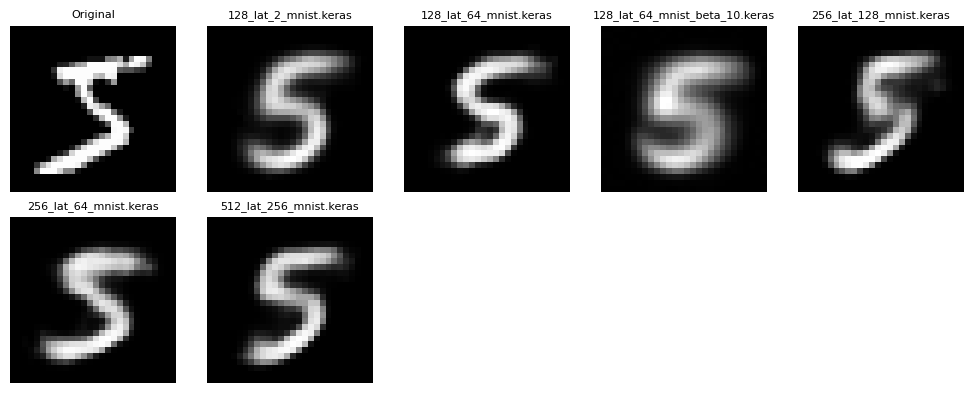

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Agregar carpeta raíz al path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

# Importar módulos propios
from data.get_data import get_mnist_data
from models_definitions.cvae import CVAE
from custom_layers.Sampling import Sampling

# Cargar datos
data = get_mnist_data()

x_train = data["x_train"]
x_test = data["x_test"]
x_val = data["x_val"]
y_train = data["y_train"]
y_test = data["y_test"]
y_val = data["y_val"]
x_train_1 = data["x_train_1"]
y_train_1 = data["y_train_1"]  


# Rutas a los modelos
ENCODER_DIR = "../../modelos_entrenados/encoders/"
DECODER_DIR = "../../modelos_entrenados/decoders/"
ORIGINAL_DIM = 28 * 28

# Obtener listas de archivos
encoder_files = sorted(os.listdir(ENCODER_DIR))
decoder_files = sorted(os.listdir(DECODER_DIR))


# Función para extraer clave
def get_key(filename):
    return "_".join(filename.split("_")[2:])  # ej: 'lat_2_mnist.keras'


# Crear diccionarios clave → path
encoders = {
    get_key(f): os.path.join(ENCODER_DIR, f)
    for f in encoder_files
    if f.endswith(".keras")
}
decoders = {
    get_key(f): os.path.join(DECODER_DIR, f)
    for f in decoder_files
    if f.endswith(".keras")
}

# Claves comunes entre encoder y decoder
common_keys = sorted(set(encoders.keys()) & set(decoders.keys()))
print(f"Encontrados {len(common_keys)} pares de modelos.")

# Imagen original
x_input = x_train[:1]  # Imagen original
cond_input = y_train[:1]  # Condición
original_image = x_input[0].reshape(28, 28)

# Guardar imágenes reconstruidas + nombres
reconstructed_images = [original_image]
model_names = ["Original"]

# Iterar sobre modelos
for key in common_keys:
    print(f"\n🧩 Cargando modelos para configuración: {key}")

    encoder_path = encoders[key]
    decoder_path = decoders[key]

    encoder = load_model(encoder_path, custom_objects={"Sampling": Sampling})
    decoder = load_model(decoder_path)

    cvae = CVAE(encoder, decoder, original_dim=ORIGINAL_DIM)
    cvae.compile(optimizer="adam")

    # Codificar y decodificar
    z_mean, z_log_var, z = cvae.encoder.predict([x_input, cond_input], verbose=0)
    reconstructed = cvae.decoder.predict([z, cond_input], verbose=0)

    # Guardar imagen
    reconstructed_images.append(reconstructed[0].reshape(28, 28))
    model_names.append(key)

    print(f"✅ Modelo '{key}' procesado.")

# Mostrar todas las imágenes en una sola figura
num_images = len(reconstructed_images)
cols = min(5, num_images)
rows = (num_images + cols - 1) // cols

plt.figure(figsize=(cols * 2, rows * 2))

for i, (img, name) in enumerate(zip(reconstructed_images, model_names)):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(name, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from keras.models import load_model

from custom_layers.Sampling import Sampling
from custom_layers.ReshapeLayer import ReshapeLayer

from data.get_data import get_mnist_data
from models_definitions.cvae import CVAE
from inferencias.inferencia import separar_digitos


data = get_mnist_data("fashion")

x_train = data["x_train"]
x_test = data["x_test"]
x_val = data["x_val"]
y_train = data["y_train"]
y_test = data["y_test"]
y_val = data["y_val"]
x_train_1 = data["x_train_1"]
y_train_1 = data["y_train_1"]  

encoder = load_model(
    "../../modelos_entrenados/encoders_fashion/en_int_256_lat_128_fashion.keras",
    custom_objects={"Sampling": Sampling},
)

decoder = load_model(
    "../../modelos_entrenados/decoders_fashion/de_int_256_lat_128_fashion.keras"
)

cvae = CVAE(encoder=encoder, decoder=decoder, original_dim=28 * 28, beta=1)

predictor = load_model(
    "../../modelos_entrenados/predictores/CCE_Conv2D_fashion.keras",
    {"ReshapeLayer": ReshapeLayer},
)


def objective(trial):
    bias = trial.suggest_float("bias", 0.1, 5.0)
    slope = trial.suggest_float("slope", 10.0, 60.0)

    # print(f"Probando bias={bias}, slope={slope}")

    try:
        bpsnr, bpsnr_d,_, _ = separar_digitos(
            x_train[:1000],
            x_train_1[:1000],
            y_train[:1000],
            y_train_1[:1000],
            cvae,
            predictor,
            bias=bias,
            slope=slope,
            Iterations=3,
        )
        # print(f"Resultado OK: bpsnr = mean: {bpsnr[0]} std: {bpsnr[1]}\n")
        # print(f"Resultado OK: bpsnr = mean: {bpsnr_d[0]} std: {bpsnr_d[1]}\n")

        return bpsnr[0]

    except Exception as e:
        print(f"Error con bias={bias}, slope={slope}: {e}")
        # Podés penalizarlo con un valor muy alto
        return float("inf")

Usando fashion como dataset


In [14]:
import optuna

# Creamos un estudio de minimización
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)  # Probamos 30 combinaciones

# Mostramos los mejores resultados
print("\n📊 Mejores hiperparámetros encontrados:")
print(study.best_params)
print("🔽 Mejor bpsnr_mean:", study.best_value)

[I 2025-08-09 17:54:28,708] A new study created in memory with name: no-name-0dc87f4c-f4e1-4cbf-855b-bcefea268663
[I 2025-08-09 17:54:32,108] Trial 0 finished with value: 7.662317276000977 and parameters: {'bias': 3.917037366898749, 'slope': 43.577316457741425}. Best is trial 0 with value: 7.662317276000977.
[I 2025-08-09 17:54:35,543] Trial 1 finished with value: 7.662317276000977 and parameters: {'bias': 3.698535209496726, 'slope': 16.07194507820241}. Best is trial 0 with value: 7.662317276000977.
[I 2025-08-09 17:54:39,154] Trial 2 finished with value: 7.662317276000977 and parameters: {'bias': 2.3173713748092832, 'slope': 22.420996103695852}. Best is trial 0 with value: 7.662317276000977.
[I 2025-08-09 17:54:42,454] Trial 3 finished with value: 7.662317276000977 and parameters: {'bias': 3.795192836363558, 'slope': 10.515348028305745}. Best is trial 0 with value: 7.662317276000977.
[I 2025-08-09 17:54:45,731] Trial 4 finished with value: 7.756838321685791 and parameters: {'bias': 1.


📊 Mejores hiperparámetros encontrados:
{'bias': 0.17606394529470876, 'slope': 48.53491166650604}
🔽 Mejor bpsnr_mean: 14.325255393981934


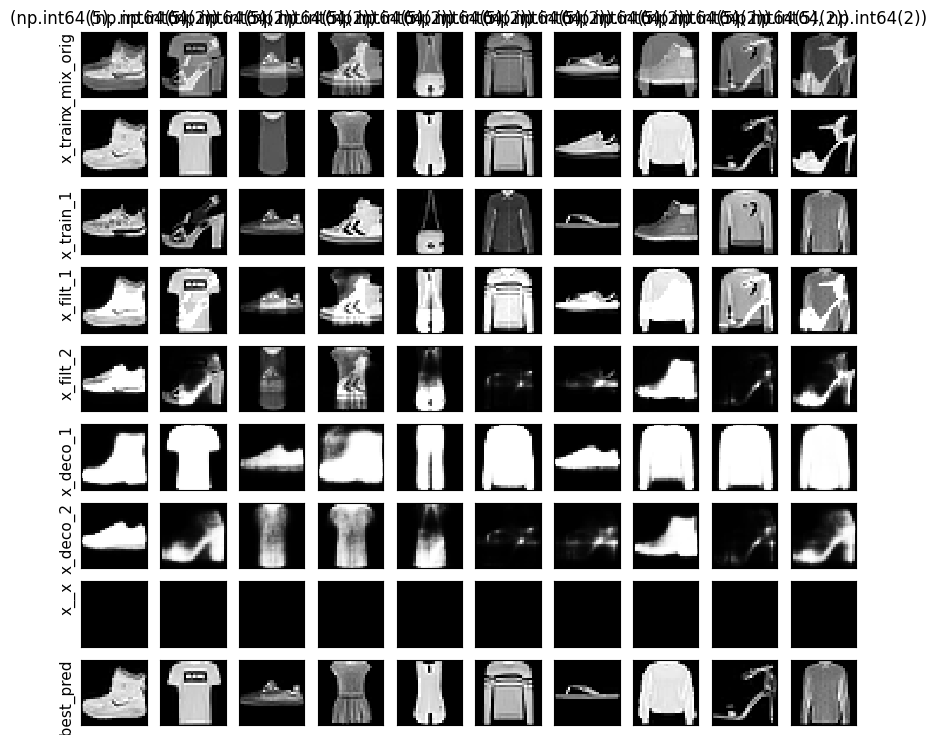

((<tf.Tensor: shape=(), dtype=float32, numpy=15.971989631652832>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.8320190906524658>),
 (<tf.Tensor: shape=(), dtype=float32, numpy=11.581478118896484>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.3360804319381714>),
 array([[2.6637650e-07, 2.9789071e-08, 8.4511174e-07, 3.2432351e-07,
         2.8462593e-05, 5.9812353e-04, 4.1467763e-05, 3.0834323e-03,
         1.9117915e-04, 9.9605584e-01],
        [9.9708366e-01, 4.0872135e-07, 2.1530248e-03, 1.4585820e-04,
         6.7398008e-07, 3.7698392e-10, 5.6945306e-04, 7.7144698e-08,
         4.6657155e-05, 5.5545531e-08],
        [1.7270341e-04, 1.7047793e-04, 4.4488008e-03, 8.6087724e-03,
         1.9192425e-04, 9.5013564e-04, 8.8355998e-03, 9.7601360e-01,
         1.1062467e-04, 4.9750443e-04],
        [3.4230159e-04, 1.1618603e-04, 1.8656489e-03, 3.4886817e-03,
         3.5416724e-05, 4.1483878e-04, 4.6092147e-01, 1.5419208e-01,
         2.1509058e-03, 3.7647256e-01],
        [1.1490942e-01

In [15]:
separar_digitos(
    x_train[:10],
    x_train_1[:10],
    y_train[:10],
    y_train_1[:10],
    cvae,
    predictor,
    Iterations=3,
    show_graph=True,
)

Mejores hiperparámetros encontrados:
{'bias': 0.17606394529470876, 'slope': 48.53491166650604}


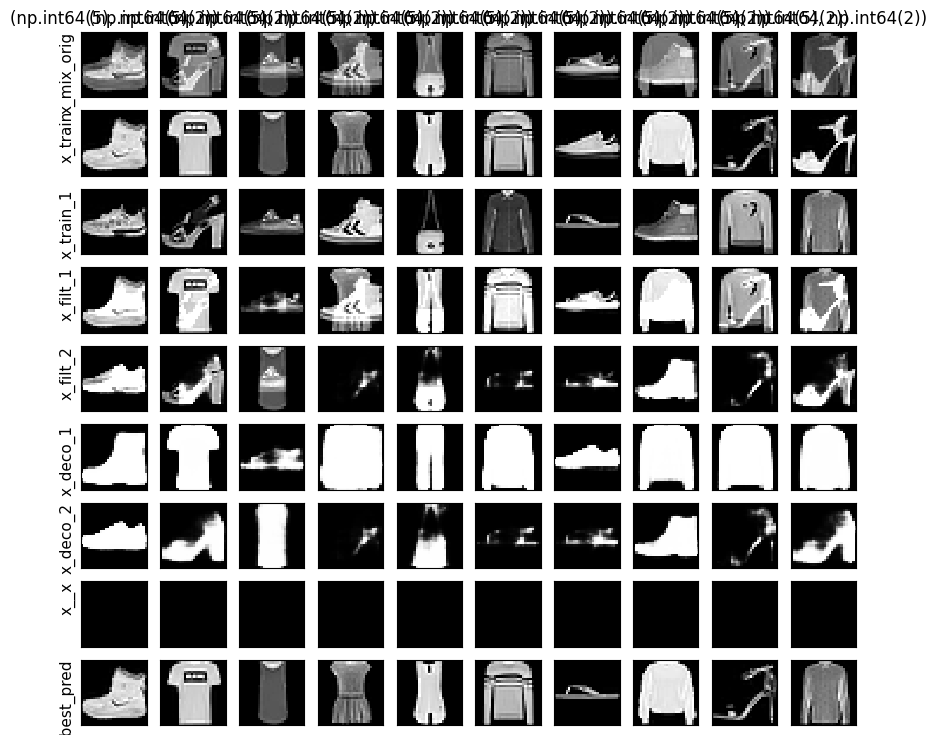

((<tf.Tensor: shape=(), dtype=float32, numpy=14.763890266418457>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.1299800872802734>),
 (<tf.Tensor: shape=(), dtype=float32, numpy=10.076642036437988>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.7941288948059082>),
 array([[3.0635942e-07, 2.2630010e-08, 5.4874999e-07, 1.2771643e-07,
         1.4300426e-05, 6.7529053e-04, 3.6354868e-05, 1.6729364e-03,
         1.7190741e-04, 9.9742812e-01],
        [9.9548829e-01, 1.7986379e-06, 3.1670993e-03, 9.0336171e-04,
         6.0944961e-07, 1.7807381e-09, 4.2714048e-04, 1.3709669e-07,
         1.1670017e-05, 1.3526208e-08],
        [6.9973626e-06, 4.3617747e-06, 5.6259934e-04, 1.7247072e-05,
         6.0703907e-05, 7.1002561e-01, 1.0805523e-04, 2.8680927e-01,
         9.8715059e-04, 1.4179617e-03],
        [1.0091259e-02, 1.9112133e-03, 3.2592244e-03, 4.5956414e-02,
         9.7435011e-05, 1.0156104e-04, 6.4863950e-01, 3.9716758e-02,
         2.5464657e-03, 2.4768019e-01],
        [5.8470652e-02

In [16]:
num_images = 10
print("Mejores hiperparámetros encontrados:")
print(study.best_params)
# study.best_value


separar_digitos(
    x_train[:10],
    x_train_1[:10],
    y_train[:10],
    y_train_1[:10],
    cvae,
    predictor,
    bias=study.best_params["bias"],
    slope=study.best_params["slope"],
    Iterations=3,
    show_graph=True,
)

Hay una mejora en la reconstrucción de las prendas, hay mayor stauración de las máscaras y mayor definición (por ejemplo las mangas de los buzos de las últimas imágenes). Hay una (duplicación? repetición?) de partes superpuesta ver taco de la última imágen.



### Prueba para mnist

Usando mnist como dataset


[I 2025-08-09 17:42:56,119] A new study created in memory with name: no-name-9440567a-cd9b-4d7d-bbb7-7db4c63b78a2
[I 2025-08-09 17:42:59,472] Trial 0 finished with value: inf and parameters: {'bias': 2.298121652663826, 'slope': 28.993000652315057}. Best is trial 0 with value: inf.


Error con bias=2.298121652663826, slope=28.993000652315057: too many values to unpack (expected 3)


[I 2025-08-09 17:43:03,051] Trial 1 finished with value: inf and parameters: {'bias': 1.2162981603292924, 'slope': 15.6202900143197}. Best is trial 0 with value: inf.


Error con bias=1.2162981603292924, slope=15.6202900143197: too many values to unpack (expected 3)


[I 2025-08-09 17:43:06,462] Trial 2 finished with value: inf and parameters: {'bias': 4.473224576990268, 'slope': 12.00759914657267}. Best is trial 0 with value: inf.


Error con bias=4.473224576990268, slope=12.00759914657267: too many values to unpack (expected 3)


[I 2025-08-09 17:43:10,426] Trial 3 finished with value: inf and parameters: {'bias': 2.717960058995749, 'slope': 47.671110091535375}. Best is trial 0 with value: inf.


Error con bias=2.717960058995749, slope=47.671110091535375: too many values to unpack (expected 3)


[I 2025-08-09 17:43:14,283] Trial 4 finished with value: inf and parameters: {'bias': 2.4816945535981785, 'slope': 16.078433220784795}. Best is trial 0 with value: inf.


Error con bias=2.4816945535981785, slope=16.078433220784795: too many values to unpack (expected 3)


[I 2025-08-09 17:43:17,978] Trial 5 finished with value: inf and parameters: {'bias': 1.457825172806845, 'slope': 34.65108642234918}. Best is trial 0 with value: inf.


Error con bias=1.457825172806845, slope=34.65108642234918: too many values to unpack (expected 3)


[I 2025-08-09 17:43:21,998] Trial 6 finished with value: inf and parameters: {'bias': 3.5025649840042425, 'slope': 48.00176409477098}. Best is trial 0 with value: inf.


Error con bias=3.5025649840042425, slope=48.00176409477098: too many values to unpack (expected 3)


[I 2025-08-09 17:43:25,832] Trial 7 finished with value: inf and parameters: {'bias': 4.697773886384216, 'slope': 42.75034266299245}. Best is trial 0 with value: inf.


Error con bias=4.697773886384216, slope=42.75034266299245: too many values to unpack (expected 3)


[I 2025-08-09 17:43:29,238] Trial 8 finished with value: inf and parameters: {'bias': 0.699846515489044, 'slope': 58.92699070903604}. Best is trial 0 with value: inf.


Error con bias=0.699846515489044, slope=58.92699070903604: too many values to unpack (expected 3)


[I 2025-08-09 17:43:32,951] Trial 9 finished with value: inf and parameters: {'bias': 4.904225768271897, 'slope': 26.585486879702525}. Best is trial 0 with value: inf.


Error con bias=4.904225768271897, slope=26.585486879702525: too many values to unpack (expected 3)


[I 2025-08-09 17:43:37,140] Trial 10 finished with value: inf and parameters: {'bias': 2.259603528355549, 'slope': 24.645354521841465}. Best is trial 0 with value: inf.


Error con bias=2.259603528355549, slope=24.645354521841465: too many values to unpack (expected 3)


[I 2025-08-09 17:43:40,759] Trial 11 finished with value: inf and parameters: {'bias': 0.11676576572871467, 'slope': 20.512269452288233}. Best is trial 0 with value: inf.


Error con bias=0.11676576572871467, slope=20.512269452288233: too many values to unpack (expected 3)


[I 2025-08-09 17:43:44,939] Trial 12 finished with value: inf and parameters: {'bias': 1.466931323511321, 'slope': 32.7967707212123}. Best is trial 0 with value: inf.


Error con bias=1.466931323511321, slope=32.7967707212123: too many values to unpack (expected 3)


[I 2025-08-09 17:43:48,731] Trial 13 finished with value: inf and parameters: {'bias': 1.684451709046527, 'slope': 10.464252352153874}. Best is trial 0 with value: inf.


Error con bias=1.684451709046527, slope=10.464252352153874: too many values to unpack (expected 3)


[I 2025-08-09 17:43:52,577] Trial 14 finished with value: inf and parameters: {'bias': 3.410255068143062, 'slope': 28.03100070425726}. Best is trial 0 with value: inf.


Error con bias=3.410255068143062, slope=28.03100070425726: too many values to unpack (expected 3)


[I 2025-08-09 17:43:56,251] Trial 15 finished with value: inf and parameters: {'bias': 0.7883348386562354, 'slope': 19.37610528071282}. Best is trial 0 with value: inf.


Error con bias=0.7883348386562354, slope=19.37610528071282: too many values to unpack (expected 3)


[I 2025-08-09 17:43:59,782] Trial 16 finished with value: inf and parameters: {'bias': 3.203492077863613, 'slope': 38.01345241021323}. Best is trial 0 with value: inf.


Error con bias=3.203492077863613, slope=38.01345241021323: too many values to unpack (expected 3)


[I 2025-08-09 17:44:03,586] Trial 17 finished with value: inf and parameters: {'bias': 1.9466465885211435, 'slope': 17.4039690878292}. Best is trial 0 with value: inf.


Error con bias=1.9466465885211435, slope=17.4039690878292: too many values to unpack (expected 3)


[I 2025-08-09 17:44:07,455] Trial 18 finished with value: inf and parameters: {'bias': 0.7252873683726939, 'slope': 28.58909333226822}. Best is trial 0 with value: inf.


Error con bias=0.7252873683726939, slope=28.58909333226822: too many values to unpack (expected 3)


[I 2025-08-09 17:44:11,327] Trial 19 finished with value: inf and parameters: {'bias': 4.016058247319051, 'slope': 22.884635087937912}. Best is trial 0 with value: inf.


Error con bias=4.016058247319051, slope=22.884635087937912: too many values to unpack (expected 3)


[I 2025-08-09 17:44:15,845] Trial 20 finished with value: inf and parameters: {'bias': 1.08583951670606, 'slope': 14.505264724754156}. Best is trial 0 with value: inf.


Error con bias=1.08583951670606, slope=14.505264724754156: too many values to unpack (expected 3)


[I 2025-08-09 17:44:19,295] Trial 21 finished with value: inf and parameters: {'bias': 4.198506845554841, 'slope': 11.379029825167486}. Best is trial 0 with value: inf.


Error con bias=4.198506845554841, slope=11.379029825167486: too many values to unpack (expected 3)


[I 2025-08-09 17:44:22,957] Trial 22 finished with value: inf and parameters: {'bias': 2.101707057965135, 'slope': 10.094784174795699}. Best is trial 0 with value: inf.


Error con bias=2.101707057965135, slope=10.094784174795699: too many values to unpack (expected 3)


[I 2025-08-09 17:44:26,939] Trial 23 finished with value: inf and parameters: {'bias': 2.8004988386821044, 'slope': 16.137548649883005}. Best is trial 0 with value: inf.


Error con bias=2.8004988386821044, slope=16.137548649883005: too many values to unpack (expected 3)


[I 2025-08-09 17:44:30,191] Trial 24 finished with value: inf and parameters: {'bias': 0.11971955504979181, 'slope': 21.582926049346256}. Best is trial 0 with value: inf.


Error con bias=0.11971955504979181, slope=21.582926049346256: too many values to unpack (expected 3)


[I 2025-08-09 17:44:34,092] Trial 25 finished with value: inf and parameters: {'bias': 2.968345985738315, 'slope': 32.392196486128924}. Best is trial 0 with value: inf.


Error con bias=2.968345985738315, slope=32.392196486128924: too many values to unpack (expected 3)


[I 2025-08-09 17:44:37,652] Trial 26 finished with value: inf and parameters: {'bias': 3.845677384265463, 'slope': 14.41435214102471}. Best is trial 0 with value: inf.


Error con bias=3.845677384265463, slope=14.41435214102471: too many values to unpack (expected 3)


[I 2025-08-09 17:44:41,361] Trial 27 finished with value: inf and parameters: {'bias': 4.468170440500288, 'slope': 29.881941411772722}. Best is trial 0 with value: inf.


Error con bias=4.468170440500288, slope=29.881941411772722: too many values to unpack (expected 3)


[I 2025-08-09 17:44:45,028] Trial 28 finished with value: inf and parameters: {'bias': 1.115317926834462, 'slope': 39.359941564674614}. Best is trial 0 with value: inf.


Error con bias=1.115317926834462, slope=39.359941564674614: too many values to unpack (expected 3)


[I 2025-08-09 17:44:49,011] Trial 29 finished with value: inf and parameters: {'bias': 2.5861990115026217, 'slope': 44.95743685179317}. Best is trial 0 with value: inf.


Error con bias=2.5861990115026217, slope=44.95743685179317: too many values to unpack (expected 3)


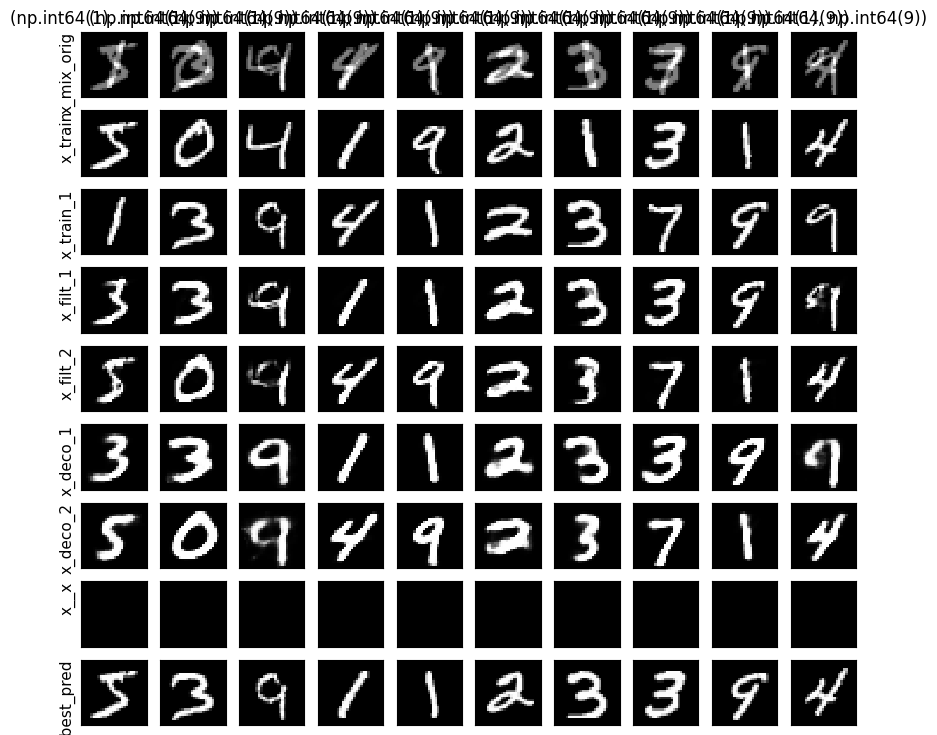


📊 Mejores hiperparámetros encontrados:
{'bias': 2.298121652663826, 'slope': 28.993000652315057}
🔽 Mejor bpsnr_mean: inf


In [ ]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from keras.models import load_model

from custom_layers.Sampling import Sampling
from custom_layers.ReshapeLayer import ReshapeLayer

from data.get_data import get_mnist_data
from models_definitions.cvae import CVAE
from inferencias.inferencia import separar_digitos


data = get_mnist_data()

x_train = data["x_train"]
x_test = data["x_test"]
x_val = data["x_val"]
y_train = data["y_train"]
y_test = data["y_test"]
y_val = data["y_val"]
x_train_1 = data["x_train_1"]
y_train_1 = data["y_train_1"]  


encoder = load_model(
    "../../modelos_entrenados/encoders/en_int_256_lat_128_mnist.keras",
    custom_objects={"Sampling": Sampling},
)

decoder = load_model(
    "../../modelos_entrenados/decoders/de_int_256_lat_128_mnist.keras"
)

cvae = CVAE(encoder=encoder, decoder=decoder, original_dim=28 * 28, beta=1)

predictor = load_model(
    "../../modelos_entrenados/predictores/CCE_Conv2D.keras",
    {"ReshapeLayer": ReshapeLayer},
)


def objective(trial):
    bias = trial.suggest_float("bias", 0.1, 5.0)
    slope = trial.suggest_float("slope", 10.0, 60.0)

    # print(f"Probando bias={bias}, slope={slope}")

    try:
        bpsnr, bpsnr_d, _ = separar_digitos(
            x_train[:1000],
            x_train_1[:1000],
            y_train[:1000],
            y_train_1[:1000],
            cvae,
            predictor,
            bias=bias,
            slope=slope,
            Iterations=3,
        )
        # print(f"Resultado OK: bpsnr = mean: {bpsnr[0]} std: {bpsnr[1]}\n")
        # print(f"Resultado OK: bpsnr = mean: {bpsnr_d[0]} std: {bpsnr_d[1]}\n")

        return bpsnr[0]

    except Exception as e:
        print(f"Error con bias={bias}, slope={slope}: {e}")
        # Podés penalizarlo con un valor muy alto
        return float("inf")
    

import optuna

# Creamos un estudio de minimización
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)  # Probamos 30 combinaciones


separar_digitos(
    x_train[:10],
    x_train_1[:10],
    y_train[:10],
    y_train_1[:10],
    cvae,
    predictor,
    Iterations=3,
    show_graph=True,
)


# Mostramos los mejores resultados
print("\n📊 Mejores hiperparámetros encontrados:")
print(study.best_params)
print("🔽 Mejor bpsnr_mean:", study.best_value)



Mejores hiperparámetros encontrados


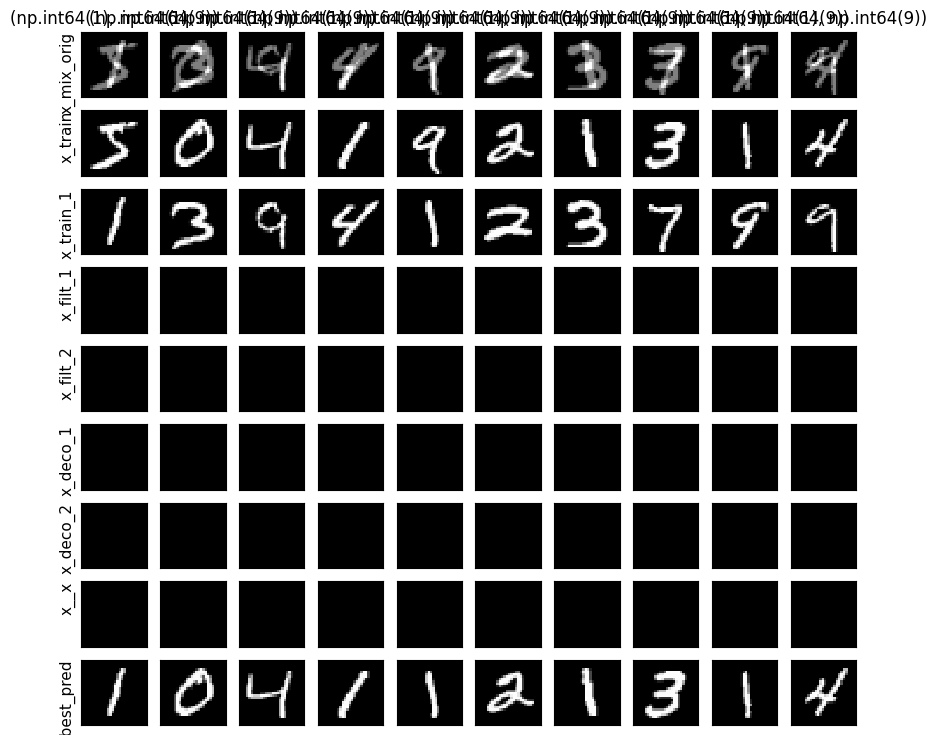

((<tf.Tensor: shape=(), dtype=float32, numpy=10.410834312438965>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.0963371992111206>),
 (<tf.Tensor: shape=(), dtype=float32, numpy=10.410834312438965>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.0963371992111206>),
 array([[3.05529011e-06, 4.34716858e-05, 1.69040086e-05, 5.82360506e-01,
         6.62925892e-09, 2.45321855e-01, 6.52802896e-08, 7.14064081e-05,
         1.64607868e-01, 7.57476361e-03],
        [8.03021789e-01, 2.67571387e-09, 6.90727320e-04, 1.91894963e-01,
         1.17820642e-09, 1.34240363e-09, 1.92103585e-06, 1.05584911e-06,
         2.39753677e-03, 1.99193531e-03],
        [1.37193683e-13, 3.02093142e-08, 1.87374272e-09, 1.06801998e-08,
         9.41399872e-01, 7.25918076e-11, 1.68053085e-10, 8.59431282e-07,
         5.66100389e-05, 5.85426353e-02],
        [2.63233087e-05, 1.79002329e-03, 1.94524432e-06, 7.97488042e-07,
         9.05915141e-01, 9.79548602e-08, 7.96109589e-07, 3.07209630e-05,
         6.12492487e-02,

In [7]:
print("Mejores hiperparámetros encontrados")


separar_digitos(
    x_train[:10],
    x_train_1[:10],
    y_train[:10],
    y_train_1[:10],
    cvae,
    predictor,
    bias=study.best_params["bias"],
    slope=study.best_params["slope"],
    Iterations=10,
    show_graph=True,
)

Con los datos de MNIST no se obseva la sturación de las máscaras pro quelos digitos tiene menos "gris".


## Metricas de Accq para un digito y dos

Usando valores de 'bias': 0.22, 'slope': 22
Usando valores de 'bias': 0.2562, 'slope': 10.0067


Usando mnist como dataset


E0000 00:00:1754778098.638800  250993 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1754778098.639328  250993 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/santi/Escritorio/tesis/CROP_1/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-08-09 19:21:38,939] A new study created in memory with name: no-name-02432348-35a1-418a-88da-674556b52997
[I 2025-0

Error con bias=3.419280441263763, slope=20.553327739288: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:21:46,395] Trial 1 finished with value: inf and parameters: {'bias': 1.3238483177967917, 'slope': 26.28907481126316}. Best is trial 0 with value: inf.


Error con bias=1.3238483177967917, slope=26.28907481126316: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:21:49,990] Trial 2 finished with value: inf and parameters: {'bias': 3.6466472249134796, 'slope': 36.46085834390404}. Best is trial 0 with value: inf.


Error con bias=3.6466472249134796, slope=36.46085834390404: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:21:53,936] Trial 3 finished with value: inf and parameters: {'bias': 1.0249985089397322, 'slope': 52.353611315124176}. Best is trial 0 with value: inf.


Error con bias=1.0249985089397322, slope=52.353611315124176: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:21:57,814] Trial 4 finished with value: inf and parameters: {'bias': 0.9999648126307421, 'slope': 55.53470550239045}. Best is trial 0 with value: inf.


Error con bias=0.9999648126307421, slope=55.53470550239045: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:22:02,032] Trial 5 finished with value: inf and parameters: {'bias': 3.9842451055482258, 'slope': 20.24646544957117}. Best is trial 0 with value: inf.


Error con bias=3.9842451055482258, slope=20.24646544957117: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:22:06,194] Trial 6 finished with value: inf and parameters: {'bias': 1.1629265100993076, 'slope': 49.05084784479095}. Best is trial 0 with value: inf.


Error con bias=1.1629265100993076, slope=49.05084784479095: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:22:10,138] Trial 7 finished with value: inf and parameters: {'bias': 2.426511003155658, 'slope': 22.780072906559642}. Best is trial 0 with value: inf.


Error con bias=2.426511003155658, slope=22.780072906559642: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:22:14,636] Trial 8 finished with value: inf and parameters: {'bias': 3.493520179932735, 'slope': 46.14217134951981}. Best is trial 0 with value: inf.


Error con bias=3.493520179932735, slope=46.14217134951981: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:22:18,566] Trial 9 finished with value: inf and parameters: {'bias': 0.17938682465786268, 'slope': 46.32054491159567}. Best is trial 0 with value: inf.


Error con bias=0.17938682465786268, slope=46.32054491159567: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:22:22,595] Trial 10 finished with value: inf and parameters: {'bias': 4.539348503438176, 'slope': 10.315717955852378}. Best is trial 0 with value: inf.


Error con bias=4.539348503438176, slope=10.315717955852378: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:22:26,862] Trial 11 finished with value: inf and parameters: {'bias': 2.4144010144455033, 'slope': 29.043486548601468}. Best is trial 0 with value: inf.


Error con bias=2.4144010144455033, slope=29.043486548601468: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:22:31,072] Trial 12 finished with value: inf and parameters: {'bias': 1.7248491851225174, 'slope': 13.697247925593917}. Best is trial 0 with value: inf.


Error con bias=1.7248491851225174, slope=13.697247925593917: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:22:34,991] Trial 13 finished with value: inf and parameters: {'bias': 3.1308724924412985, 'slope': 32.515465121885995}. Best is trial 0 with value: inf.


Error con bias=3.1308724924412985, slope=32.515465121885995: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:22:39,139] Trial 14 finished with value: inf and parameters: {'bias': 1.7869620332116432, 'slope': 22.578877775039615}. Best is trial 0 with value: inf.


Error con bias=1.7869620332116432, slope=22.578877775039615: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:22:43,360] Trial 15 finished with value: inf and parameters: {'bias': 4.700873526734778, 'slope': 16.854897820009647}. Best is trial 0 with value: inf.


Error con bias=4.700873526734778, slope=16.854897820009647: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:22:47,367] Trial 16 finished with value: inf and parameters: {'bias': 2.9390728523359777, 'slope': 39.74356822516165}. Best is trial 0 with value: inf.


Error con bias=2.9390728523359777, slope=39.74356822516165: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:22:52,275] Trial 17 finished with value: inf and parameters: {'bias': 0.2390341265108613, 'slope': 26.93520774834333}. Best is trial 0 with value: inf.


Error con bias=0.2390341265108613, slope=26.93520774834333: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:22:56,557] Trial 18 finished with value: inf and parameters: {'bias': 1.8491503429574474, 'slope': 27.44816952015799}. Best is trial 0 with value: inf.


Error con bias=1.8491503429574474, slope=27.44816952015799: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:23:00,399] Trial 19 finished with value: inf and parameters: {'bias': 2.7968851682142652, 'slope': 37.64956957664109}. Best is trial 0 with value: inf.


Error con bias=2.7968851682142652, slope=37.64956957664109: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:23:04,091] Trial 20 finished with value: inf and parameters: {'bias': 4.2117863671069244, 'slope': 17.887865559221964}. Best is trial 0 with value: inf.


Error con bias=4.2117863671069244, slope=17.887865559221964: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:23:07,735] Trial 21 finished with value: inf and parameters: {'bias': 3.578482240645208, 'slope': 34.34252128855799}. Best is trial 0 with value: inf.


Error con bias=3.578482240645208, slope=34.34252128855799: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:23:11,504] Trial 22 finished with value: inf and parameters: {'bias': 3.6848560888534228, 'slope': 41.02476508504348}. Best is trial 0 with value: inf.


Error con bias=3.6848560888534228, slope=41.02476508504348: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:23:15,362] Trial 23 finished with value: inf and parameters: {'bias': 3.267910801369246, 'slope': 24.86442256463193}. Best is trial 0 with value: inf.


Error con bias=3.267910801369246, slope=24.86442256463193: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:23:19,201] Trial 24 finished with value: inf and parameters: {'bias': 4.142936551755843, 'slope': 30.2403894718143}. Best is trial 0 with value: inf.


Error con bias=4.142936551755843, slope=30.2403894718143: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:23:24,562] Trial 25 finished with value: inf and parameters: {'bias': 2.1751053839021006, 'slope': 35.60087942108868}. Best is trial 0 with value: inf.


Error con bias=2.1751053839021006, slope=35.60087942108868: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:23:29,039] Trial 26 finished with value: inf and parameters: {'bias': 0.5639076124195332, 'slope': 41.855266293702655}. Best is trial 0 with value: inf.


Error con bias=0.5639076124195332, slope=41.855266293702655: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:23:32,679] Trial 27 finished with value: inf and parameters: {'bias': 3.84769897090601, 'slope': 31.08390376370969}. Best is trial 0 with value: inf.


Error con bias=3.84769897090601, slope=31.08390376370969: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:23:36,333] Trial 28 finished with value: inf and parameters: {'bias': 2.7342851174924614, 'slope': 16.310488796982355}. Best is trial 0 with value: inf.


Error con bias=2.7342851174924614, slope=16.310488796982355: 'tuple' object has no attribute 'get'


[I 2025-08-09 19:23:40,317] Trial 29 finished with value: inf and parameters: {'bias': 1.2865366317895888, 'slope': 58.38470152637841}. Best is trial 0 with value: inf.


Error con bias=1.2865366317895888, slope=58.38470152637841: 'tuple' object has no attribute 'get'

📊 Mejores hiperparámetros encontrados:
{'bias': 3.419280441263763, 'slope': 20.553327739288}
🔽 Mejor bpsnr_mean: inf


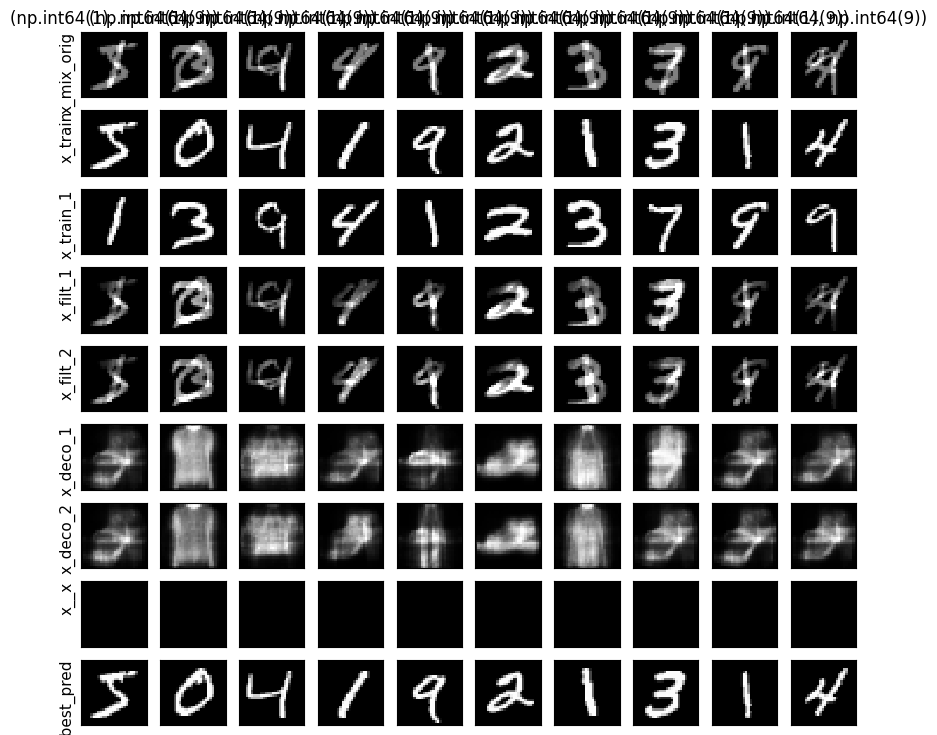

({'bpsnr': (<tf.Tensor: shape=(), dtype=float32, numpy=14.74305534362793>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.8407979607582092>),
  'bpsnr_d': (<tf.Tensor: shape=(), dtype=float32, numpy=10.176918983459473>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.8134135007858276>),
  'predictions_1': array([[1.15111411e-01, 1.03817787e-04, 1.42035517e-03, 3.30631994e-02,
          5.56846964e-04, 8.36827278e-01, 2.23983102e-03, 3.68747751e-05,
          2.68364768e-03, 7.95672555e-03],
         [4.37832326e-01, 9.57518758e-04, 2.65328765e-01, 1.66285913e-02,
          3.46078500e-02, 4.54728454e-02, 1.13115788e-01, 6.50760718e-03,
          7.86187574e-02, 9.29897302e-04],
         [1.88320741e-01, 8.46551964e-04, 9.07315989e-04, 4.14131791e-05,
          1.17687171e-03, 2.64949519e-02, 1.68921461e-03, 5.74778323e-06,
          7.80516803e-01, 2.65873183e-07],
         [2.10575701e-04, 1.51348752e-06, 7.00697046e-06, 3.46777415e-05,
          3.67245804e-07, 9.99615252e-01, 8.642

In [3]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from keras.models import load_model

from custom_layers.Sampling import Sampling
from custom_layers.ReshapeLayer import ReshapeLayer

from data.get_data import get_mnist_data
from models_definitions.cvae import CVAE
from inference.inference import unmix


data = get_mnist_data()

x_train = data["x_train"]
x_test = data["x_test"]
x_val = data["x_val"]
y_train = data["y_train"]
y_test = data["y_test"]
y_val = data["y_val"]
x_train_1 = data["x_train_1"]
y_train_1 = data["y_train_1"]  

encoder = load_model(
    "../../trained_models/encoders_fashion/en_int_256_lat_128_fashion.keras",
    custom_objects={"Sampling": Sampling},
)

decoder = load_model(
    "../../trained_models/decoders_fashion/de_int_256_lat_128_fashion.keras"
)

cvae = CVAE(encoder=encoder, decoder=decoder, original_dim=28 * 28, beta=1)

predictor = load_model(
    "../../trained_models/predictores/CCE_Conv2D_fashion.keras",
    {"ReshapeLayer": ReshapeLayer},
)


def objective(trial):
    bias = trial.suggest_float("bias", 0.1, 5.0)
    slope = trial.suggest_float("slope", 10.0, 60.0)

    # print(f"Probando bias={bias}, slope={slope}")

    try:
        metris = unmix(
            x_train[:1000],
            x_train_1[:1000],
            y_train[:1000],
            y_train_1[:1000],
            cvae,
            predictor,
            bias=bias,
            slope=slope,
            Iterations=3,
        )
        # print(f"Resultado OK: bpsnr = mean: {bpsnr[0]} std: {bpsnr[1]}\n")
        # print(f"Resultado OK: bpsnr = mean: {bpsnr_d[0]} std: {bpsnr_d[1]}\n")

        return metris.get("bpsnr")

    except Exception as e:
        print(f"Error con bias={bias}, slope={slope}: {e}")
        # Podés penalizarlo con un valor muy alto
        return float("inf")
    

import optuna

# Creamos un estudio de minimización
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30) 

# Mostramos los mejores resultados
print("\n📊 Mejores hiperparámetros encontrados:")
print(study.best_params)
print("🔽 Mejor bpsnr_mean:", study.best_value)


unmix(
    x_train[:10],
    x_train_1[:10],
    y_train[:10],
    y_train_1[:10],
    cvae,
    predictor,
    bias=0.22,
    slope=10,
    Iterations=3,
    show_graph=True,
)

In [ ]:
metrics = unmix(
    x_train[:1000],
    x_train_1[:1000],
    y_train[:1000],
    y_train_1[:1000],
    cvae,
    predictor,
    bias=study.best_params["bias"],
    slope=study.best_params["slope"],
    Iterations=5,
    show_graph=False,
)

#print(f"m: {m} ")
print(f"Accuracy al menos uno {metris.get("accuracy_at_least_one")}")
print(f"Accuracy ambos {metris.get("accuracy_both")}")

Accuracy al menos uno 0.7929999828338623
Accuracy ambos 0.13099999725818634
